In [2]:
import polars as pl

In [3]:
DATA_FOLDER = 'D:/code/third_party/polars_guide/data'

# Data Structures

## Series

A _Series_ is a one-dimensional data structure that holds a sequence of values. All
values in a Series have the same data type, like Integers, Floats, or Strings.

Series can exist on their own, but they’re most commonly used as columns in a _DataFrame_.

In [4]:
sales_series = pl.Series("sales", [150.00, 300.00, 250.00])
sales_series

sales
f64
150.0
300.0
250.0


## Data Frame

A _DataFrame_ is a two-dimensional data structure that organizes data in a table
format, with rows and columns. Internally, it’s represented as a sequence of multiple
Series, each with the same length.

In [5]:
sales_df = pl.DataFrame({
    "sales": sales_series,
    "customer_id": [24, 25, 26],
})

sales_df

sales,customer_id
f64,i64
150.0,24
300.0,25
250.0,26


## Lazy Frame

While a DataFrame stores data directly in memory, a _LazyFrame_ contains only instructions for reading and processing data.

None of the read operations or transformations applied to a LazyFrame
are executed immediately; instead, they are deferred until needed, hence the term
“lazy” evaluation.

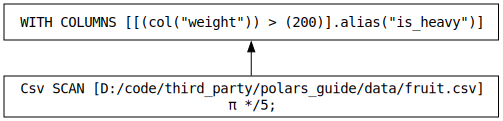

In [6]:
lazy_df = pl.scan_csv(f"{DATA_FOLDER}/fruit.csv").with_columns(
    is_heavy=pl.col("weight") > 200
)

lazy_df.show_graph()

# Data Type

- Array - Fixed-length List data type
- List - Variable-length List data type
- Null Type representing Null/None values
- Object Type - for wrapping arbitrary Python objects

In [7]:
coordinates = pl.DataFrame(
    [
        pl.Series("point_2d", [[1, 3], [2, 5]]),
        pl.Series("point_3d", [[1, 7, 3], [8, 1, 0]]),
    ],
    schema={
        "point_2d": pl.Array(shape=2, inner=pl.Int64),
        "point_3d": pl.Array(shape=3, inner=pl.Int64),
    },
)

coordinates

point_2d,point_3d
"array[i64, 2]","array[i64, 3]"
"[1, 3]","[1, 7, 3]"
"[2, 5]","[8, 1, 0]"


In [8]:
coordinates_list = pl.DataFrame(
    {
        "point_2d": [[1, 3], [2, 5]],
        "point_3d": [[1, 7, 3], [8, 1, 0]],
    },
    schema={
        "point_2d": pl.List(pl.Int64),
        "point_3d": pl.List(pl.Int64),
    },
)

coordinates_list

point_2d,point_3d
list[i64],list[i64]
"[1, 3]","[1, 7, 3]"
"[2, 5]","[8, 1, 0]"


In [9]:
rating_series = pl.Series(
    "ratings",
    [
        {"Movie": "Cars", "Theatre": "NE", "Avg_Rating": 4.5},
        {"Movie": "Toy Story", "Theatre": "ME", "Avg_Rating": 4.9},
    ],
)

rating_series

ratings
struct[3]
"{""Cars"",""NE"",4.5}"
"{""Toy Story"",""ME"",4.9}"


# Missing Values

In [10]:
missing_df = pl.DataFrame(
    {
        "value": [None, 2, 3, 4, None, None, 7, 8, 9, None],
    },
)

missing_df

value
i64
null
2
3
4
null
null
7
8
9


In [11]:
missing_df.schema

Schema([('value', Int64)])

In [12]:
missing_df.with_columns(
    # single value
    filled_with_single=pl.col("value").fill_null(-1),
    # strategies
    forward=pl.col("value").fill_null(strategy="forward"),
    backward=pl.col("value").fill_null(strategy="backward"),
    min=pl.col("value").fill_null(strategy="min"),
    max=pl.col("value").fill_null(strategy="max"),
    mean=pl.col("value").fill_null(strategy="mean"),
    zero=pl.col("value").fill_null(strategy="zero"),
    one=pl.col("value").fill_null(strategy="one"),
    # expression
    expression_mean=pl.col("value").fill_null(pl.col("value").mean()),
)

value,filled_with_single,forward,backward,min,max,mean,zero,one,expression_mean
i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
null,-1,null,2,2,9,5,0,1,5.5
2,2,2,2,2,2,2,2,2,2.0
3,3,3,3,3,3,3,3,3,3.0
4,4,4,4,4,4,4,4,4,4.0
null,-1,4,7,2,9,5,0,1,5.5
null,-1,4,7,2,9,5,0,1,5.5
7,7,7,7,7,7,7,7,7,7.0
8,8,8,8,8,8,8,8,8,8.0
9,9,9,9,9,9,9,9,9,9.0


# Data Type Conversion

## Expression

In [13]:
string_df = pl.DataFrame({"id": ["10000", "20000", "30000"]})
print(string_df)

int_df = string_df.select(pl.col("id").cast(pl.UInt16))
print(int_df)

shape: (3, 1)
┌───────┐
│ id    │
│ ---   │
│ str   │
╞═══════╡
│ 10000 │
│ 20000 │
│ 30000 │
└───────┘
shape: (3, 1)
┌───────┐
│ id    │
│ ---   │
│ u16   │
╞═══════╡
│ 10000 │
│ 20000 │
│ 30000 │
└───────┘


## Data Frame

In [14]:
data_types_df = pl.DataFrame(
    {
        "id": [10000, 20000, 30000],
        "value": [1.0, 2.0, 3.0],
        "value2": ["1", "2", "3"],
    }
)

print(data_types_df)

shape: (3, 3)
┌───────┬───────┬────────┐
│ id    ┆ value ┆ value2 │
│ ---   ┆ ---   ┆ ---    │
│ i64   ┆ f64   ┆ str    │
╞═══════╪═══════╪════════╡
│ 10000 ┆ 1.0   ┆ 1      │
│ 20000 ┆ 2.0   ┆ 2      │
│ 30000 ┆ 3.0   ┆ 3      │
└───────┴───────┴────────┘


In [15]:
print(data_types_df.cast(pl.UInt16))

shape: (3, 3)
┌───────┬───────┬────────┐
│ id    ┆ value ┆ value2 │
│ ---   ┆ ---   ┆ ---    │
│ u16   ┆ u16   ┆ u16    │
╞═══════╪═══════╪════════╡
│ 10000 ┆ 1     ┆ 1      │
│ 20000 ┆ 2     ┆ 2      │
│ 30000 ┆ 3     ┆ 3      │
└───────┴───────┴────────┘


In [16]:
print(data_types_df.cast({
    "id": pl.UInt16,
    "value": pl.Float32,
    "value2": pl.UInt8,
}))

shape: (3, 3)
┌───────┬───────┬────────┐
│ id    ┆ value ┆ value2 │
│ ---   ┆ ---   ┆ ---    │
│ u16   ┆ f32   ┆ u8     │
╞═══════╪═══════╪════════╡
│ 10000 ┆ 1.0   ┆ 1      │
│ 20000 ┆ 2.0   ┆ 2      │
│ 30000 ┆ 3.0   ┆ 3      │
└───────┴───────┴────────┘


In [17]:
print(data_types_df.cast({
    pl.Float64: pl.Float32,
    pl.String: pl.UInt8,
}))

shape: (3, 3)
┌───────┬───────┬────────┐
│ id    ┆ value ┆ value2 │
│ ---   ┆ ---   ┆ ---    │
│ i64   ┆ f32   ┆ u8     │
╞═══════╪═══════╪════════╡
│ 10000 ┆ 1.0   ┆ 1      │
│ 20000 ┆ 2.0   ┆ 2      │
│ 30000 ┆ 3.0   ┆ 3      │
└───────┴───────┴────────┘


In [18]:
import polars.selectors as cs
print(data_types_df.cast({
    cs.numeric(): pl.UInt16
}))

shape: (3, 3)
┌───────┬───────┬────────┐
│ id    ┆ value ┆ value2 │
│ ---   ┆ ---   ┆ ---    │
│ u16   ┆ u16   ┆ str    │
╞═══════╪═══════╪════════╡
│ 10000 ┆ 1     ┆ 1      │
│ 20000 ┆ 2     ┆ 2      │
│ 30000 ┆ 3     ┆ 3      │
└───────┴───────┴────────┘


# API

## Eager API

In [19]:
trips = pl.read_parquet(f"{DATA_FOLDER}/taxi/yellow_tripdata_2022-01.parquet")

In [20]:
trips.head(3)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
i64,datetime[ns],datetime[ns],f64,f64,f64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,"""N""",142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.1,1.0,"""N""",236,42,1,8.0,0.5,0.5,4.0,0.0,0.3,13.3,0.0,0.0
2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,"""N""",166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0


In [21]:
sum_per_vendor = trips.group_by("VendorID").agg(
    pl.col("total_amount").sum(),
    pl.col("trip_distance").sum(),
)

sum_per_vendor.head(3)

VendorID,total_amount,trip_distance
i64,f64,f64
1,1.4291e7,2.2174e6
6,212038.93,45929.08
5,2159.92,536.8


In [22]:
income_per_distance_per_vendor = sum_per_vendor.select(
    "VendorID",
    income_per_distance=pl.col("total_amount") / pl.col("trip_distance"),
)

income_per_distance_per_vendor.sort(
    by="income_per_distance",
    descending=True
).head(3)

VendorID,income_per_distance
i64,f64
1,6.445081
6,4.61666
5,4.023696


## Lazy API

- Optimizations
- Catch schema errors

In [23]:
names_lf = pl.LazyFrame(
    {
        "name": ["Alice", "Bob", "Charlie"],
        "age": [25, 30, 35]
    },
)

erroneous_query = names_lf.with_columns(
    sliced_age=pl.col("age").str.slice(1, 3)
)

"""
A LazyFrame is evaluated and converted into a DataFrame only when
you invoke the lf.collect() method.
"""

# Will Fail. Lazy API allows queries to fail fast
# result_df = erroneous_query.collect()

'\nA LazyFrame is evaluated and converted into a DataFrame only when\nyou invoke the lf.collect() method.\n'

# Expressions

In [24]:
fruit = pl.read_csv(f"{DATA_FOLDER}/fruit.csv")
fruit.head(3)

name,weight,color,is_round,origin
str,i64,str,bool,str
"""Avocado""",200,"""green""",false,"""South America"""
"""Banana""",120,"""yellow""",false,"""Asia"""
"""Blueberry""",1,"""blue""",false,"""North America"""


## Select Old & Create New Columns

In [25]:
fruit.select(
    # pick col by name
    pl.col("name"),
    # pick col by regex
    pl.col("^.*or.*$"),
    # pick col and transform
    pl.col("weight") / 1000,
    # pick col but cannot transform
    "is_round",
)

name,color,origin,weight,is_round
str,str,str,f64,bool
"""Avocado""","""green""","""South America""",0.2,false
"""Banana""","""yellow""","""Asia""",0.12,false
"""Blueberry""","""blue""","""North America""",0.001,false
"""Cantaloupe""","""orange""","""Africa""",2.5,true
"""Cranberry""","""red""","""North America""",0.002,false
"""Elderberry""","""black""","""Europe""",0.001,false
"""Orange""","""orange""","""Asia""",0.13,true
"""Papaya""","""orange""","""South America""",1.0,false
"""Peach""","""orange""","""Asia""",0.15,true


## Create New Columns

In [26]:
fruit.with_columns(
    pl.lit(True).alias("is_fruit"),
    is_berry=pl.col("name").str.ends_with("berry"),
)

name,weight,color,is_round,origin,is_fruit,is_berry
str,i64,str,bool,str,bool,bool
"""Avocado""",200,"""green""",false,"""South America""",true,false
"""Banana""",120,"""yellow""",false,"""Asia""",true,false
"""Blueberry""",1,"""blue""",false,"""North America""",true,true
"""Cantaloupe""",2500,"""orange""",true,"""Africa""",true,false
"""Cranberry""",2,"""red""",false,"""North America""",true,true
"""Elderberry""",1,"""black""",false,"""Europe""",true,true
"""Orange""",130,"""orange""",true,"""Asia""",true,false
"""Papaya""",1000,"""orange""",false,"""South America""",true,false
"""Peach""",150,"""orange""",true,"""Asia""",true,false


## Filtering Rows

In [27]:
fruit.filter(
    (pl.col("weight") > 1000) & pl.col("is_round")
)

name,weight,color,is_round,origin
str,i64,str,bool,str
"""Cantaloupe""",2500,"""orange""",true,"""Africa"""
"""Watermelon""",5000,"""green""",true,"""Africa"""


## Aggregating

In [28]:
fruit.group_by(
    # group name gets set as 'origin
    pl.col("origin").str.split(" ").list.last()
).agg(
    # actual aggregations are calculated here

    # returns the number of rows in the group
    pl.len(),
    average_weight=pl.col("weight").mean()
)

origin,len,average_weight
str,u32,f64
"""Asia""",3,133.333333
"""Europe""",1,1.0
"""Africa""",2,3750.0
"""America""",4,300.75


## Sorting Rows

In [29]:
fruit.sort(
    pl.col("name").str.len_bytes(),
    descending=True,
)

name,weight,color,is_round,origin
str,i64,str,bool,str
"""Cantaloupe""",2500,"""orange""",true,"""Africa"""
"""Elderberry""",1,"""black""",false,"""Europe"""
"""Watermelon""",5000,"""green""",true,"""Africa"""
"""Blueberry""",1,"""blue""",false,"""North America"""
"""Cranberry""",2,"""red""",false,"""North America"""
"""Avocado""",200,"""green""",false,"""South America"""
"""Banana""",120,"""yellow""",false,"""Asia"""
"""Orange""",130,"""orange""",true,"""Asia"""
"""Papaya""",1000,"""orange""",false,"""South America"""


# Pivot

## Pivot - Long to Wide

In [30]:
multiple_grades = pl.DataFrame(
    {
        "student": [
            "Jeroen", "Jeroen", "Jeroen", "Jeroen", "Jeroen", "Jeroen", "Thijs", "Thijs", "Thijs", "Thijs", "Thijs", "Thijs",
        ],
        "subject": [
            "Math", "Math", "Math", "Science", "Science", "Science", "Math", "Math", "Math", "Science", "Science", "Science",
        ],
        "grade": [85, 88, 85, 60, 66, 63, 51, 79, 62, 82, 85, 82],
    }
)

print(multiple_grades)

shape: (12, 3)
┌─────────┬─────────┬───────┐
│ student ┆ subject ┆ grade │
│ ---     ┆ ---     ┆ ---   │
│ str     ┆ str     ┆ i64   │
╞═════════╪═════════╪═══════╡
│ Jeroen  ┆ Math    ┆ 85    │
│ Jeroen  ┆ Math    ┆ 88    │
│ Jeroen  ┆ Math    ┆ 85    │
│ Jeroen  ┆ Science ┆ 60    │
│ Jeroen  ┆ Science ┆ 66    │
│ …       ┆ …       ┆ …     │
│ Thijs   ┆ Math    ┆ 79    │
│ Thijs   ┆ Math    ┆ 62    │
│ Thijs   ┆ Science ┆ 82    │
│ Thijs   ┆ Science ┆ 85    │
│ Thijs   ┆ Science ┆ 82    │
└─────────┴─────────┴───────┘


In [31]:
# pivot the DataFrame to calculate the average grade per student
multiple_grades.pivot(
    index="student",
    on="subject",
    values="grade",
    aggregate_function="mean",
)

student,Math,Science
str,f64,f64
"""Jeroen""",86.0,63.0
"""Thijs""",64.0,83.0


## Unpivot - Wide to Long

In [32]:
grades_wide = pl.DataFrame(
    {
        "student": ["Jeroen", "Thijs", "Ritchie"],
        "math": [85, 78, 92],
        "science": [90, 82, 85],
        "history": [88, 80, 87],
    }
)

print(grades_wide)

shape: (3, 4)
┌─────────┬──────┬─────────┬─────────┐
│ student ┆ math ┆ science ┆ history │
│ ---     ┆ ---  ┆ ---     ┆ ---     │
│ str     ┆ i64  ┆ i64     ┆ i64     │
╞═════════╪══════╪═════════╪═════════╡
│ Jeroen  ┆ 85   ┆ 90      ┆ 88      │
│ Thijs   ┆ 78   ┆ 82      ┆ 80      │
│ Ritchie ┆ 92   ┆ 85      ┆ 87      │
└─────────┴──────┴─────────┴─────────┘


In [33]:
grades_wide.unpivot(
    index=["student"],
    on=["math", "science", "history"],
    variable_name="subject",
    value_name="grade",
)

student,subject,grade
str,str,i64
"""Jeroen""","""math""",85
"""Thijs""","""math""",78
"""Ritchie""","""math""",92
"""Jeroen""","""science""",90
"""Thijs""","""science""",82
"""Ritchie""","""science""",85
"""Jeroen""","""history""",88
"""Thijs""","""history""",80
"""Ritchie""","""history""",87


# Explode

In [34]:
grades_nested = pl.DataFrame(
    {
        "student": ["Jeroen", "Thijs", "Ritchie"],
        "math": [[85, 90, 88], [78, 82, 80], [92, 85, 87]],
    }
)

print(grades_nested)

shape: (3, 2)
┌─────────┬──────────────┐
│ student ┆ math         │
│ ---     ┆ ---          │
│ str     ┆ list[i64]    │
╞═════════╪══════════════╡
│ Jeroen  ┆ [85, 90, 88] │
│ Thijs   ┆ [78, 82, 80] │
│ Ritchie ┆ [92, 85, 87] │
└─────────┴──────────────┘


In [35]:
grades_nested.explode("math")

student,math
str,i64
"""Jeroen""",85
"""Jeroen""",90
"""Jeroen""",88
"""Thijs""",78
"""Thijs""",82
"""Thijs""",80
"""Ritchie""",92
"""Ritchie""",85
"""Ritchie""",87


The exploded columns must all yield the same number of resulting rows,
otherwise you’ll get an error. So Pivot to Long then Explode if necessary.

# Partition

In [36]:
sales = pl.DataFrame(
    {
        "OrderID": [1, 2, 3, 4, 5, 6],
        "Product": ["A", "B", "A", "C", "B", "A"],
        "Quantity": [10, 5, 8, 7, 3, 12],
        "Region": ["North", "South", "North", "West", "South", "West"],
    }
)

In [37]:
sales.partition_by(
    "Region",
    include_key=False,
)

[shape: (2, 3)
 ┌─────────┬─────────┬──────────┐
 │ OrderID ┆ Product ┆ Quantity │
 │ ---     ┆ ---     ┆ ---      │
 │ i64     ┆ str     ┆ i64      │
 ╞═════════╪═════════╪══════════╡
 │ 1       ┆ A       ┆ 10       │
 │ 3       ┆ A       ┆ 8        │
 └─────────┴─────────┴──────────┘,
 shape: (2, 3)
 ┌─────────┬─────────┬──────────┐
 │ OrderID ┆ Product ┆ Quantity │
 │ ---     ┆ ---     ┆ ---      │
 │ i64     ┆ str     ┆ i64      │
 ╞═════════╪═════════╪══════════╡
 │ 2       ┆ B       ┆ 5        │
 │ 5       ┆ B       ┆ 3        │
 └─────────┴─────────┴──────────┘,
 shape: (2, 3)
 ┌─────────┬─────────┬──────────┐
 │ OrderID ┆ Product ┆ Quantity │
 │ ---     ┆ ---     ┆ ---      │
 │ i64     ┆ str     ┆ i64      │
 ╞═════════╪═════════╪══════════╡
 │ 4       ┆ C       ┆ 7        │
 │ 6       ┆ A       ┆ 12       │
 └─────────┴─────────┴──────────┘]